# Detecção de Fake News com BERTimbau e Pooling Alternativo

Este notebook implementa e avalia dois modelos para a detecção de fake news em português, utilizando o modelo BERTimbau como base.

- **Modelo Baseline:** BERTimbau com um classificador linear sobre o embedding do token.
- **Modelo com Pooling Alternativo:** Uma variação que concatena o embedding do  com a média dos embeddings de todos os tokens da sequência (mean pooling).

O objetivo é comparar o desempenho das duas abordagens na classificação de notícias do dataset Fake.Br Corpus.

In [1]:
!pip install torch transformers datasets scikit-learn matplotlib seaborn python-pptx umap-learn reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 18.3 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak, Image, Table, TableStyle
from reportlab.lib.units import inch
from reportlab.lib import colors
from pptx import Presentation
from pptx.util import Inches
import zipfile

# Configurações
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Hiperparâmetros
EPOCHS = 3
BATCH_SIZE = 16
MAX_LEN = 256
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

Usando dispositivo: cuda


In [3]:
try:
    drive.mount("/content/drive")
    DRIVE_PATH = "/content/drive/MyDrive/T2_FakeNews_Output/"
    os.makedirs(DRIVE_PATH, exist_ok=True)
    print(f"Arquivos serão salvos em: {DRIVE_PATH}")
except:
    print("Google Drive não montado. Os arquivos serão salvos localmente.")
    DRIVE_PATH = "./output/"
    os.makedirs(DRIVE_PATH, exist_ok=True)
    print(f"Arquivos serão salvos em: {DRIVE_PATH}")

Mounted at /content/drive
Arquivos serão salvos em: /content/drive/MyDrive/T2_FakeNews_Output/


## B. Obtenção e Preparação do Dataset

In [4]:
# Clonar o repositório do Fake.Br Corpus
!git clone https://github.com/roneysco/Fake.br-Corpus.git

Cloning into 'Fake.br-Corpus'...
remote: Enumerating objects: 28763, done.
remote: Total 28763 (delta 0), reused 0 (delta 0), pack-reused 28763 (from 1)
Receiving objects: 100% (28763/28763), 37.10 MiB | 15.97 MiB/s, done.
Resolving deltas: 100% (14129/14129), done.
Updating files: 100% (21602/21602), done.


# Carregar e preparar os dados


In [5]:
# O arquivo pre-processed.csv contendo todas as notícias (fake e true) e o rótulo.
df = pd.read_csv("Fake.br-Corpus/preprocessed/pre-processed.csv")

# Renomear a coluna de texto para 'text'
df = df.rename(columns={'preprocessed_news': 'text'})

# Garantir que a coluna 'text' não tenha valores nulos e remover espaços em branco
df = df.dropna(subset=['text'])
df["text"] = df["text"].str.strip()

# Mapear os rótulos para inteiros: 0 para 'true' e 1 para 'fake'
df['label'] = df['label'].map({'true': 0, 'fake': 1})

# Divisão em treino, validação e teste (80/10/10)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=RANDOM_SEED, stratify=df["label"]
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=RANDOM_SEED, stratify=temp_labels
)

print(f"Tamanho do treino: {len(train_texts)}")
print(f"Tamanho da validação: {len(val_texts)}")
print(f"Tamanho do teste: {len(test_texts)}")

Tamanho do treino: 5760
Tamanho da validação: 720
Tamanho do teste: 720


##Tokenização e DataLoader

In [6]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [7]:
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        texts=texts.to_numpy(),
        labels=labels.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

train_data_loader = create_data_loader(train_texts, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_texts, val_labels, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)

##Modelo: Baseline (CLS Pooling)

In [8]:
class BaselineBertClassifier(torch.nn.Module):

    def __init__(self, n_classes):
        super(BaselineBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = torch.nn.Dropout(p=0.3)
        self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

In [9]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [10]:
model_baseline = BaselineBertClassifier(n_classes=2)
model_baseline = model_baseline.to(device)

optimizer_baseline = AdamW(model_baseline.parameters(), lr=2e-5)
total_steps_baseline = len(train_data_loader) * EPOCHS

scheduler_baseline = get_linear_schedule_with_warmup(
    optimizer_baseline,
    num_warmup_steps=0,
    num_training_steps=total_steps_baseline
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

history_baseline = {
    'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
}

print("Iniciando Treinamento do Modelo Baseline...")
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model_baseline, train_data_loader, loss_fn, optimizer_baseline, device, scheduler_baseline, len(train_texts)
    )

    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        model_baseline, val_data_loader, loss_fn, device, len(val_texts)
    )

    print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')
    print()

    history_baseline['train_acc'].append(train_acc.item())
    history_baseline['train_loss'].append(train_loss)
    history_baseline['val_acc'].append(val_acc.item())
    history_baseline['val_loss'].append(val_loss)

torch.save(model_baseline.state_dict(), os.path.join(DRIVE_PATH, 'baseline.pt'))
print("Modelo Baseline salvo.")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Iniciando Treinamento do Modelo Baseline...
Epoch 1/3
----------


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Train loss 0.2480 accuracy 0.9083
Val   loss 0.2958 accuracy 0.8972

Epoch 2/3
----------
Train loss 0.1226 accuracy 0.9646
Val   loss 0.1990 accuracy 0.9528

Epoch 3/3
----------
Train loss 0.0570 accuracy 0.9875
Val   loss 0.2087 accuracy 0.9542

Modelo Baseline salvo.


##Modelo: Variante com Pooling Alternativo (CLS + Mean Pooling)

In [11]:
class CustomBertimbauClassifier(torch.nn.Module):

    def __init__(self, pretrained_model_name=PRE_TRAINED_MODEL_NAME, num_labels=2):
        super(CustomBertimbauClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size * 2, num_labels)

    def mean_pooling(self, token_embeddings, attention_mask):
        # Expande a máscara de atenção para multiplicar os embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        # Soma os embeddings ponderados pela máscara
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        # Conta o número de tokens válidos (para a média)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        # Retorna a média
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        # 1. CLS Embedding
        cls_embedding = last_hidden_state[:, 0, :]

        # 2. Mean Pooling
        mean_pool_embedding = self.mean_pooling(last_hidden_state, attention_mask)

        # 3. Concatenação
        concatenated_embedding = torch.cat((cls_embedding, mean_pool_embedding), dim=1)

        pooled_output = self.dropout(concatenated_embedding)
        logits = self.classifier(pooled_output)
        return logits

In [12]:
model_variant = CustomBertimbauClassifier(num_labels=2)
model_variant = model_variant.to(device)

optimizer_variant = AdamW(model_variant.parameters(), lr=2e-5)
total_steps_variant = len(train_data_loader) * EPOCHS

scheduler_variant = get_linear_schedule_with_warmup(
    optimizer_variant,
    num_warmup_steps=0,
    num_training_steps=total_steps_variant
)

history_variant = {
    'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
}

print("Iniciando Treinamento do Modelo Variante...")
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model_variant, train_data_loader, loss_fn, optimizer_variant, device, scheduler_variant, len(train_texts)
    )

    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        model_variant, val_data_loader, loss_fn, device, len(val_texts)
    )

    print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')
    print()

    history_variant['train_acc'].append(train_acc.item())
    history_variant['train_loss'].append(train_loss)
    history_variant['val_acc'].append(val_acc.item())
    history_variant['val_loss'].append(val_loss)

torch.save(model_variant.state_dict(), os.path.join(DRIVE_PATH, 'pooling_variant.pt'))
print("Modelo Variante salvo.")

Iniciando Treinamento do Modelo Variante...
Epoch 1/3
----------
Train loss 0.2474 accuracy 0.9056
Val   loss 0.1460 accuracy 0.9458

Epoch 2/3
----------
Train loss 0.1239 accuracy 0.9644
Val   loss 0.2765 accuracy 0.9264

Epoch 3/3
----------
Train loss 0.0590 accuracy 0.9859
Val   loss 0.2113 accuracy 0.9375

Modelo Variante salvo.


##Avaliação Quantitativa

In [13]:
def get_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

In [14]:
print("Obtendo predições do modelo Baseline...")
y_pred_baseline, y_test_baseline = get_predictions(model_baseline, test_data_loader)
print("Obtendo predições do modelo Variante...")
y_pred_variant, y_test_variant = get_predictions(model_variant, test_data_loader)

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

metrics_baseline = calculate_metrics(y_test_baseline, y_pred_baseline)
metrics_variant = calculate_metrics(y_test_variant, y_pred_variant)

print("\n" + "="*30)
print("Métricas de Avaliação (Teste)")
print("="*30)
print("Modelo Baseline:")
print(f"  Accuracy: {metrics_baseline['accuracy']:.4f}")
print(f"  Precision: {metrics_baseline['precision']:.4f}")
print(f"  Recall: {metrics_baseline['recall']:.4f}")
print(f"  F1-Score: {metrics_baseline['f1']:.4f}")

print("\nModelo Variante:")
print(f"  Accuracy: {metrics_variant['accuracy']:.4f}")
print(f"  Precision: {metrics_variant['precision']:.4f}")
print(f"  Recall: {metrics_variant['recall']:.4f}")
print(f"  F1-Score: {metrics_variant['f1']:.4f}")

Obtendo predições do modelo Baseline...
Obtendo predições do modelo Variante...

Métricas de Avaliação (Teste)
Modelo Baseline:
  Accuracy: 0.9542
  Precision: 0.9560
  Recall: 0.9542
  F1-Score: 0.9541

Modelo Variante:
  Accuracy: 0.9528
  Precision: 0.9548
  Recall: 0.9528
  F1-Score: 0.9527


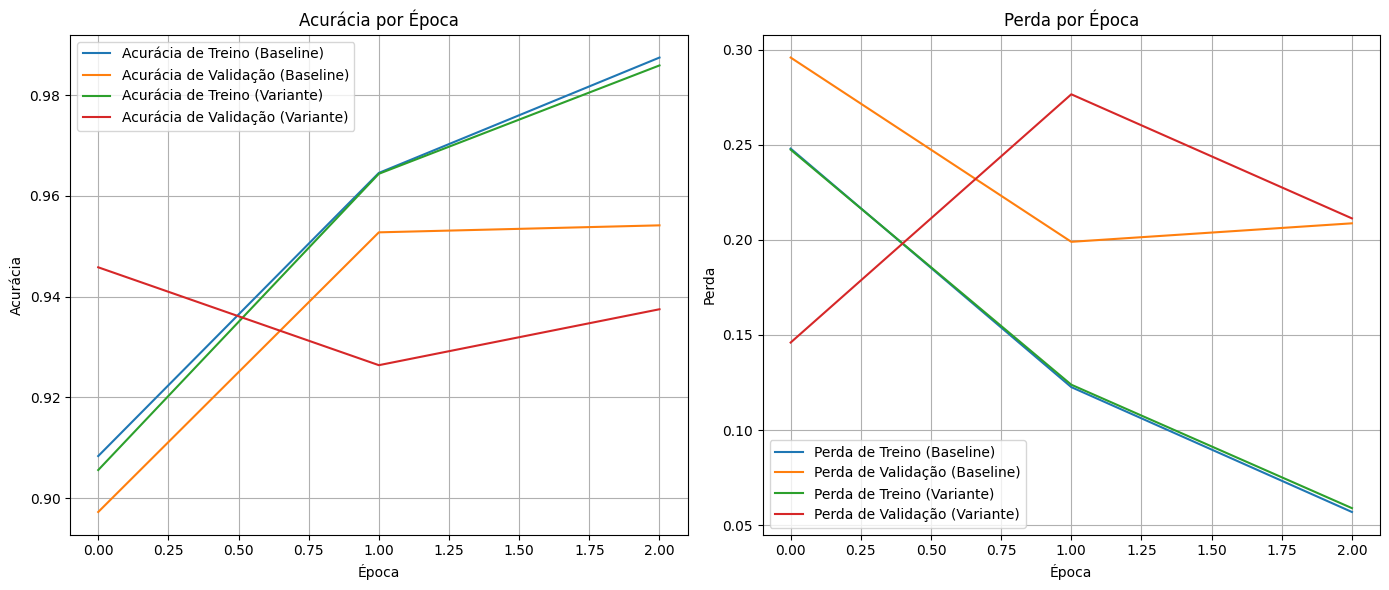

In [15]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_baseline["train_acc"], label="Acurácia de Treino (Baseline)")
plt.plot(history_baseline["val_acc"], label="Acurácia de Validação (Baseline)")
plt.plot(history_variant["train_acc"], label="Acurácia de Treino (Variante)")
plt.plot(history_variant["val_acc"], label="Acurácia de Validação (Variante)")
plt.title("Acurácia por Época")
plt.ylabel("Acurácia")
plt.xlabel("Época")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_baseline["train_loss"], label="Perda de Treino (Baseline)")
plt.plot(history_baseline["val_loss"], label="Perda de Validação (Baseline)")
plt.plot(history_variant["train_loss"], label="Perda de Treino (Variante)")
plt.plot(history_variant["val_loss"], label="Perda de Validação (Variante)")
plt.title("Perda por Época")
plt.ylabel("Perda")
plt.xlabel("Época")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(DRIVE_PATH, "training_curves.png"))
plt.show()

##Matrizes de Confusão

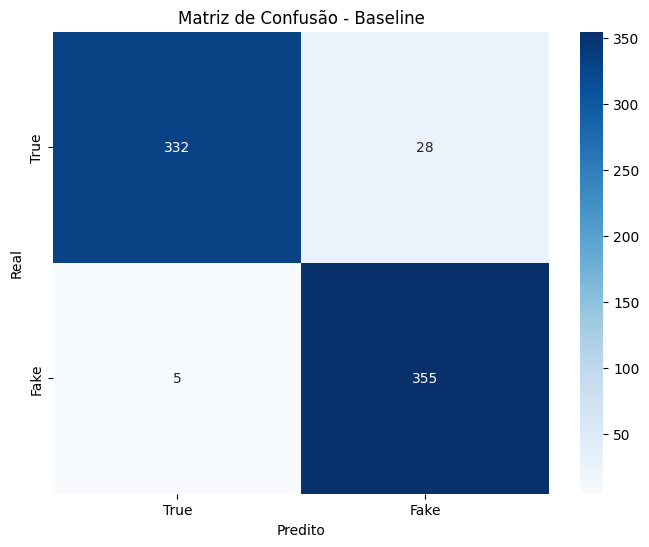

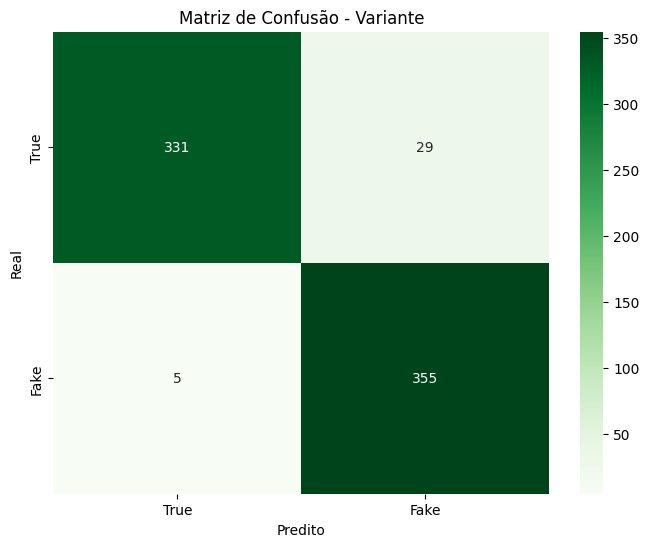

In [16]:
# Matriz de confusão - Baseline
cm_baseline = confusion_matrix(y_test_baseline, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.title('Matriz de Confusão - Baseline')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.savefig(os.path.join(DRIVE_PATH, 'confusion_matrix_baseline.png'))
plt.show()

# Matriz de confusão - Variante
cm_variant = confusion_matrix(y_test_variant, y_pred_variant)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_variant, annot=True, fmt='d', cmap='Greens',
            xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.title('Matriz de Confusão - Variante')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.savefig(os.path.join(DRIVE_PATH, 'confusion_matrix_variant.png'))
plt.show()

###Análise Qualitativa

In [17]:
# Análise de exemplos
def show_examples(model_name, y_true, y_pred, texts, num_examples=3):
    print(f"\n{'='*60}")
    print(f"Exemplos - {model_name}")
    print(f"{'='*60}")

    # Exemplos corretos
    correct_idx = [i for i in range(len(y_true)) if y_true[i] == y_pred[i]]
    print(f"\nExemplos CORRETOS (total: {len(correct_idx)}):")
    for i in correct_idx[:num_examples]:
        label = 'Fake' if y_true[i] == 1 else 'True'
        print(f"\n[{label}] {texts[i][:150]}...")

    # Exemplos incorretos
    incorrect_idx = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
    print(f"\nExemplos INCORRETOS (total: {len(incorrect_idx)}):")
    for i in incorrect_idx[:num_examples]:
        true_label = 'Fake' if y_true[i] == 1 else 'True'
        pred_label = 'Fake' if y_pred[i] == 1 else 'True'
        print(f"\nReal: {true_label} | Predito: {pred_label}")
        print(f"{texts[i][:150]}...")

# Obter textos de teste
test_texts_list = test_texts.tolist()
show_examples('Baseline', y_test_baseline.numpy(), y_pred_baseline.numpy(), test_texts_list)
show_examples('Variante', y_test_variant.numpy(), y_pred_variant.numpy(), test_texts_list)


Exemplos - Baseline

Exemplos CORRETOS (total: 687):

[True] testes misseis coreia norte representam algum risco avioes comerciais chances sao pequenas missil falhar detritos podem ser perigo misseis coreia nort...

[Fake] vandalismo presidencial presidenta danificado movel planalto agu informou ira processar judicialmente atraves ministerio justica revista semanal istoe...

[True] mpf pede claudia cruz cumpra pena regime fechado documento protocolado sistema justica federal parana mulher eduardo cunha tres sao reus processo lava...

Exemplos INCORRETOS (total: 33):

Real: True | Predito: Fake
aecio neves cuspiu cara metade eleitores brasileiros ilusao lider indicado reconstruir pais tempestade petista assolou contas publicas nacionais dedic...

Real: True | Predito: Fake
kevin rose the new york times muitos democratas estarao busca indicacao presidencial partido maioria provavelmente concorda punhado questoes basicas s...

Real: True | Predito: Fake
trump diz nao ficara contente core